# Figure 3. Meridional and time mean profiles of vertically integrated moisture diagnostics.

[Skip code and jump to the figure](#Show-the-figure)

In [1]:
import warnings

warnings.filterwarnings("ignore")
from dataclasses import dataclass

import iris
import matplotlib.pyplot as plt
import numpy as np
from aeolus.calc import meridional_mean, precip_sum
from aeolus.io import load_data
from aeolus.model import lfric
from aeolus.plot import (
    all_sim_file_label,
    capitalise,
    cube_minmeanmax_str,
    figsave,
    subplot_label_generator,
    tex2cf_units,
)

Local modules

In [2]:
import paths
from common import CONST, DC, KW_ZERO_LINE, N_RES, SIMULATIONS

Show all simulations

In [3]:
show_sim = [*SIMULATIONS.keys()]

## Load regridded time-mean data

In [4]:
# Combine two datasets into one cube list
dset = {}
for sim_label in show_sim:
    dset_averages = dset[sim_label] = load_data(
        paths.data_proc
        / SIMULATIONS[sim_label].work_name
        / f"{SIMULATIONS[sim_label].work_name}_averages_*_time_mean_and_regr_{N_RES}.nc".lower()
    )
    dset_inst_diag = load_data(
        paths.data_proc
        / SIMULATIONS[sim_label].work_name
        / f"{SIMULATIONS[sim_label].work_name}_inst_diag_*_time_mean_and_regr_{N_RES}.nc".lower()
    )
    dset_averages = iris.cube.CubeList(
        cube
        for cube in dset_averages
        if cube.var_name
        not in [
            "tot_col_w_kinetic_energy",
            "tot_col_uv_kinetic_energy",
            "cell_area",
        ]
    )
    dset[sim_label] = dset_averages + dset_inst_diag

# Print dataset contents
for i, cube in enumerate(dset[sim_label]):
    print(f"---|---|-{'-'*30}-|-{'-'*60}")
    print(f"{i:<2d} | {cube.ndim} | {str(cube.var_name):>30} | {cube.name():>60}")

---|---|--------------------------------|-------------------------------------------------------------
0  | 3 |                           m_cl |                                    cloud_liquid_mixing_ratio
---|---|--------------------------------|-------------------------------------------------------------
1  | 3 |                           m_ci |                                       cloud_ice_mixing_ratio
---|---|--------------------------------|-------------------------------------------------------------
2  | 2 |                    tot_col_m_v |                       atmosphere_mass_content_of_water_vapor
---|---|--------------------------------|-------------------------------------------------------------
3  | 3 |                  bulk_fraction |                                          bulk_cloud_fraction
---|---|--------------------------------|-------------------------------------------------------------
4  | 2 |                   tot_col_m_ci |                         atmosph

## Make plots

Define diagnostics

In [5]:
@dataclass
class Diag:
    recipe: callable
    title: str
    units: str


DIAGS = {
    "t_sfc": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.t_sfc),
        title="Surface Temperature",
        units="$K$",
    ),
    "toa_olr": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.toa_olr),
        title="TOA Outgoing Longwave Radiation",
        units="$W$ $m^{-2}$",
    ),
    "caf": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.caf),
        title="Cloud Fraction",
        units="%",
    ),
    "tot_col_m_v": Diag(
        recipe=lambda cl: cl.extract_cube("tot_col_m_v"),
        title="Total Column Water Vapour",
        units="$kg$ $m^{-2}$",
    ),
    "tot_col_m_c": Diag(
        recipe=lambda cl: cl.extract_cube("tot_col_m_c"),
        title="Total Column Cloud (Liquid+Ice)",
        units="$kg$ $m^{-2}$",
    ),
    "tot_col_m_c_sum": Diag(
        recipe=lambda cl: cl.extract_cube("tot_col_m_ci")
        + cl.extract_cube("tot_col_m_cl"),
        title="Total Column Cloud (Liquid+Ice)",
        units="$kg$ $m^{-2}$",
    ),
    "tot_col_m_cl": Diag(
        recipe=lambda cl: cl.extract_cube("tot_col_m_cl"),
        title="Total Column Cloud Liquid",
        units="$kg$ $m^{-2}$",
    ),
    "tot_col_m_ci": Diag(
        recipe=lambda cl: cl.extract_cube("tot_col_m_ci"),
        title="Total Column Cloud Ice",
        units="$kg$ $m^{-2}$",
    ),
    "ls_prec": Diag(
        recipe=lambda cl: cl.extract_cube("ls_prec") / CONST.condensible_density,
        title="Large-scale Precipitation Rate",
        units="$mm$ $day^{-1}$",
    ),
    "conv_prec": Diag(
        recipe=lambda cl: cl.extract_cube("conv_prec") / CONST.condensible_density,
        title="Convective Precipitation Rate",
        units="$mm$ $day^{-1}$",
    ),
    "tot_prec": Diag(
        recipe=lambda cl: precip_sum(cl, const=CONST, model=lfric),
        title="Total Precipitation Rate",
        units="$mm$ $day^{-1}$",
    ),
    # "tot_col_uv_kinetic_energy": Diag(
    #     recipe=lambda cl: cl.extract_cube("tot_col_uv_kinetic_energy"),
    #     title="Total Column Horizontal Kinetic Energy",
    #     units="$10^6$ $J$ $m^{-2}$",
    # ),
    # "tot_col_w_kinetic_energy": Diag(
    #     recipe=lambda cl: cl.extract_cube("tot_col_w_kinetic_energy"),
    #     title="Total Column Vertical Kinetic Energy",
    #     units="$J$ $m^{-2}$",
    # ),
}

Assemble the figure using selected diagnostics

In [6]:
diag_keys = ["tot_col_m_v", "tot_col_m_c", "tot_col_m_cl", "tot_col_m_ci"]
fmt = "pretty"
reduce_func = lambda cube: meridional_mean(cube, model=lfric)


fig = plt.figure(figsize=(8, 2 * len(diag_keys)), layout="constrained")
mosaic = [[i] for i in diag_keys]
axd = fig.subplot_mosaic(mosaic)

iletters = subplot_label_generator()
for diag_key in diag_keys:
    ax = axd[diag_key]
    for sim_label in show_sim:
        cube = reduce_func(DIAGS[diag_key].recipe(dset[sim_label]))
        cube.convert_units(tex2cf_units(DIAGS[diag_key].units))
        if iris.util.is_masked(cube.data):
            continue
        else:
            mmm_str = cube_minmeanmax_str(
                cube,
                fmt=fmt,
                precision=1,
                sep=" | ",
                eq_sign=": ",
            ).split(" | ")[1]
            # print(diag_key, sim_label, e)
            (x,) = cube.dim_coords
            h = ax.plot(
                x.points,
                cube.data,
                markevery=0.05,
                markersize=5,
                markeredgecolor="w",
                markeredgewidth=0.5,
                **SIMULATIONS[sim_label].kw_plt,
                label=f"{SIMULATIONS[sim_label].title} | {mmm_str}",
            )
    ax.legend(
        frameon=False,
        # loc="upper left",
    )
    ax.set_title(
        f"({next(iletters)})",
        loc="left",
        fontdict={"weight": "bold"},
        pad=3,
    )
    ax.set_title(
        f"{DIAGS[diag_key].title} [{DIAGS[diag_key].units}]",
        loc="right",
        fontdict={"weight": "bold"},
        pad=3,
    )
    ax.set_xticks(np.arange(-180, 181, 30))
    ax.set_xlim(-180, 180)
    ax.tick_params(labelsize="small")
    ax.set_xlabel(f"{capitalise(x.name())} [{x.units}]", size="small", labelpad=1)
    for xval in [-90, 0, 90]:
        ax.axvline(x=xval, **KW_ZERO_LINE)
plt.close()

# Show the figure

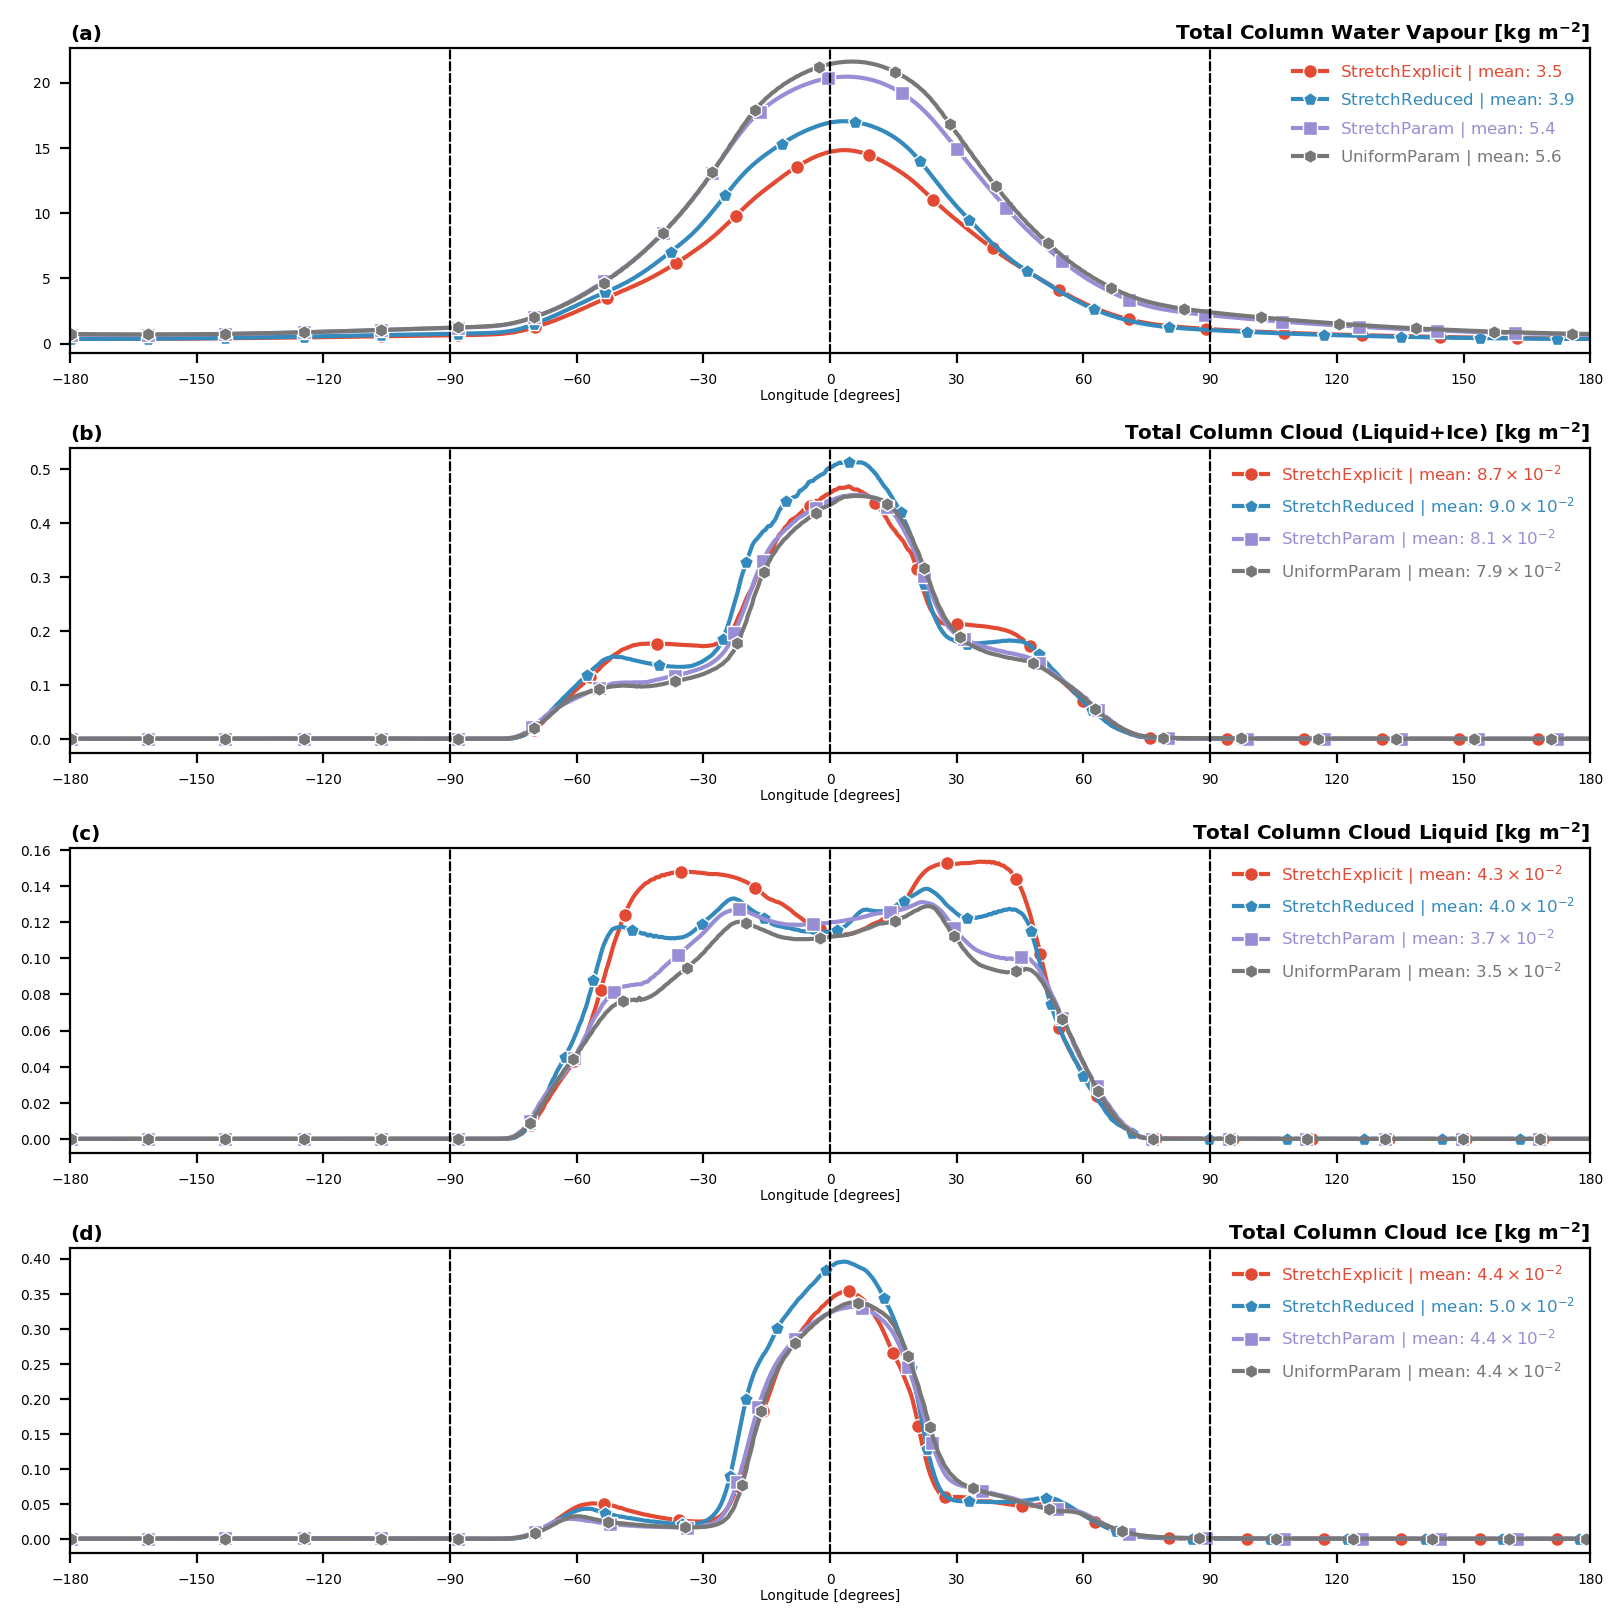

In [7]:
fig

- **Meridional and time mean profiles of vertically integrated moisture diagnostics in $kg$ $m^{-2}$**
- **(a) water vapor, (b) total cloud (liquid plus ice), (c) cloud liquid, (d) cloud ice.**
- **_StretchExplicit_ is shown in red, _StretchReduced_ in blue, _StretchParam_ in purple, and _UniformParam_ in gray.**

In [8]:
# and save it
figsave(
    fig,
    paths.figures / f"regr__{all_sim_file_label(show_sim)}__{'_'.join(diag_keys)}__tmm",
)

Saved to ../figures/regr__hab1_mod_c192_s10e_s10r_s10p_p__tot_col_m_v_tot_col_m_c_tot_col_m_cl_tot_col_m_ci__tmm.pdf
Size: 56.5 KB
